#  Movie Success Prediction and Sentiment Analysis
**Project Domain:** Data Science | NLP | Regression  


## 📖 Introduction

This project analyzes IMDb’s Top 1000 movies to predict box office gross revenue and understand sentiment from movie overviews. 
We apply Natural Language Processing (NLP) to extract sentiment, and build a regression model to estimate commercial success.


##  Load and Inspect Dataset

We begin by loading the dataset and reviewing the structure, datatypes, and sample records.


In [2]:
import pandas as pd
df=pd.read_csv("imdb_top_1000.csv")
print("shape of the dataset" , df.shape)
df.head()


shape of the dataset (1000, 16)


,Poster_Link,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,https://m.media-amazon.com/images/M/MV5BMDFkYT...,The Shawshank Redemption,1994,A,142 min,Drama,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,"28,341,469"
1,https://m.media-amazon.com/images/M/MV5BM2MyNj...,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
2,https://m.media-amazon.com/images/M/MV5BMTMxNT...,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
3,https://m.media-amazon.com/images/M/MV5BMWMwMG...,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"
4,https://m.media-amazon.com/images/M/MV5BMWU4N2...,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,"4,360,000"


##  Data Cleaning and Preprocessing

Handle missing values, clean numeric fields (`Runtime`, `Gross`), convert to appropriate types, and extract the primary genre.


In [4]:
df.drop_duplicates(inplace=True)
df.dropna(subset=['Gross','IMDB_Rating','Runtime','Overview'],inplace=True)

df['Runtime']=df['Runtime'].astype(str)
df['Runtime']=df['Runtime'].str.replace('min','').str.strip()
df['Runtime']=pd.to_numeric(df['Runtime'],errors='coerce')

df['Gross']=df['Gross'].astype(str)
df['Gross']=df['Gross'].str.replace(',','')
df['Gross']=pd.to_numeric(df['Gross'],errors='coerce')
df.dropna(subset=['Runtime','Gross',],inplace=True)
df.reset_index(drop=True,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 831 entries, 0 to 830
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Poster_Link    831 non-null    object 
 1   Series_Title   831 non-null    object 
 2   Released_Year  831 non-null    object 
 3   Certificate    785 non-null    object 
 4   Runtime        831 non-null    int64  
 5   Genre          831 non-null    object 
 6   IMDB_Rating    831 non-null    float64
 7   Overview       831 non-null    object 
 8   Meta_score     750 non-null    float64
 9   Director       831 non-null    object 
 10  Star1          831 non-null    object 
 11  Star2          831 non-null    object 
 12  Star3          831 non-null    object 
 13  Star4          831 non-null    object 
 14  No_of_Votes    831 non-null    int64  
 15  Gross          831 non-null    int64  
dtypes: float64(2), int64(3), object(11)
memory usage: 104.0+ KB


In [3]:
print(df.columns)

Index(['Poster_Link', 'Series_Title', 'Released_Year', 'Certificate',
       'Runtime', 'Genre', 'IMDB_Rating', 'Overview', 'Meta_score', 'Director',
       'Star1', 'Star2', 'Star3', 'Star4', 'No_of_Votes', 'Gross'],
      dtype='object')


In [5]:
df['Gross']=pd.to_numeric(df['Gross'],errors='coerce')
df['Gross_Million']=df['Gross']/1_000_000
df['Released_Year']=pd.to_numeric(df['Released_Year'],errors='coerce')
df['Primary_Genre']=df['Genre'].astype(str).str.split(',').str[0]
df_model=df[['IMDB_Rating','Meta_score','Runtime','No_of_Votes','Gross_Million','Overview','Primary_Genre']].copy()
df_model.dropna(inplace=True)

In [5]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


## Feature Engineering

We derive new features like `Gross_Million` and extract the primary genre. 
We also use VADER to generate a sentiment score from the movie overview.


In [6]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\AK\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

## Sentiment Analysis using VADER

VADER (Valence Aware Dictionary and sEntiment Reasoner) is applied to analyze sentiment of movie overviews. 
Each overview is scored and categorized into Positive, Neutral, or Negative.


In [6]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid=SentimentIntensityAnalyzer()

df_model['Sentiment_Score']=df_model['Overview'].apply(lambda x: sid.polarity_scores(str(x))['compound'])
df_model["Sentiment_Label"]=df_model["Sentiment_Score"].apply(lambda x:'Positive' if x>0.05 else 'Negative' if x<-0.05 else 'Neutral')
df_model[['Overview', 'Sentiment_Score','Sentiment_Label']].head()

                                                       

,Overview,Sentiment_Score,Sentiment_Label
0,Two imprisoned men bond over a number of years...,-0.4019,Negative
1,An organized crime dynasty's aging patriarch t...,-0.6705,Negative
2,When the menace known as the Joker wreaks havo...,-0.8176,Negative
3,The early life and career of Vito Corleone in ...,-0.4767,Negative
4,A jury holdout attempts to prevent a miscarria...,0.5423,Positive


##  Visual Analysis

We visualize the distribution of sentiment, and genre-based trends to gain better understanding.


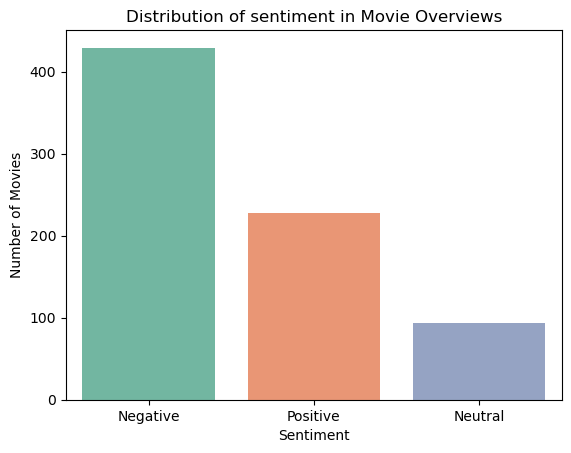

In [7]:
import  seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(data=df_model,
              x="Sentiment_Label", hue='Sentiment_Label',legend=False,  palette="Set2")
plt.title("Distribution of sentiment in Movie Overviews")
plt.xlabel("Sentiment")
plt.ylabel("Number of Movies")

plt.show()

##  Regression Model to Predict Gross Revenue

We build a Linear Regression model to predict `Gross_Million` using engineered features. 
We also evaluate it using MAE, RMSE, and R2 score.


In [8]:
df_model=df_model.drop(columns=["Sentiment_Label"],errors='ignore')


In [9]:
df_model=pd.get_dummies(df_model,columns=['Primary_Genre'],drop_first=True)

In [10]:
y=df_model['Gross_Million']
x=df_model.drop(columns=["Gross_Million"])

In [11]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.02,random_state=42)

In [12]:
x=pd.get_dummies(x,drop_first=True)


In [13]:
x=x.drop(columns=["Overview","Director","Actor_1","Actor_2"],errors="ignore")
x.dtypes
x.select_dtypes(include="object").columns

Index([], dtype='object')

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

model=LinearRegression()
model.fit(x_train, y_train)


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


##  Feature Importance

This section shows which features contributed most to the model’s prediction of revenue.


In [15]:
from sklearn.metrics import mean_absolute_error , root_mean_squared_error, r2_score
import numpy as np
y_pred=model.predict(x_test)
mae=mean_absolute_error(y_test,y_pred)
rmse=root_mean_squared_error(y_test,y_pred)
r2=r2_score(y_test,y_pred)
print(f"Mean Absolute Error (MAE): {mae:.2f} Million")
print(f"Root Mean Squared Error (RMSE):{rmse:.2f} Million")
print(f"R2 Score:{r2:.3f}")

Mean Absolute Error (MAE): 60.17 Million
Root Mean Squared Error (RMSE):95.97 Million
R2 Score:0.421


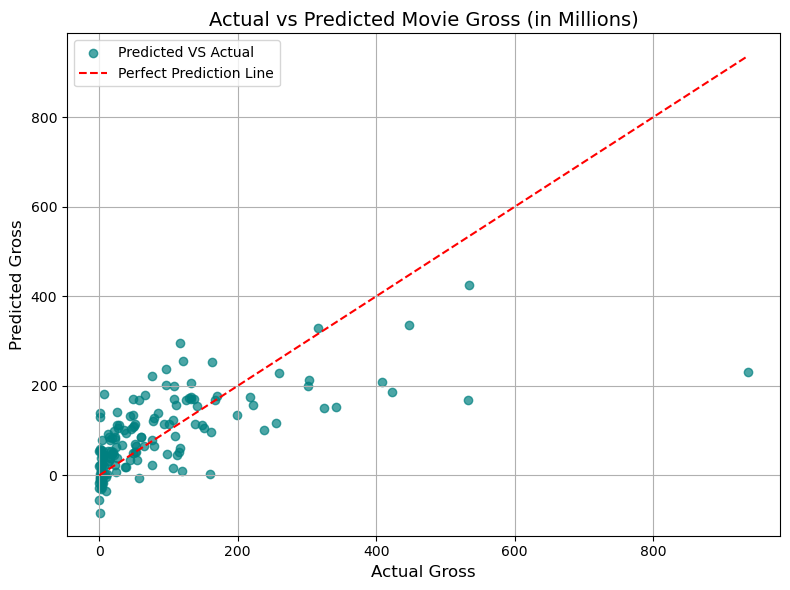

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
plt.scatter(y_test,y_pred,alpha=0.7,color='teal',label="Predicted VS Actual ")
plt.plot([y.min(),y.max()],[y.min(),y.max()],"r--",label="Perfect Prediction Line")

plt.title("Actual vs Predicted Movie Gross (in Millions)",fontsize=14)
plt.xlabel("Actual Gross", fontsize=12)
plt.ylabel("Predicted Gross",fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

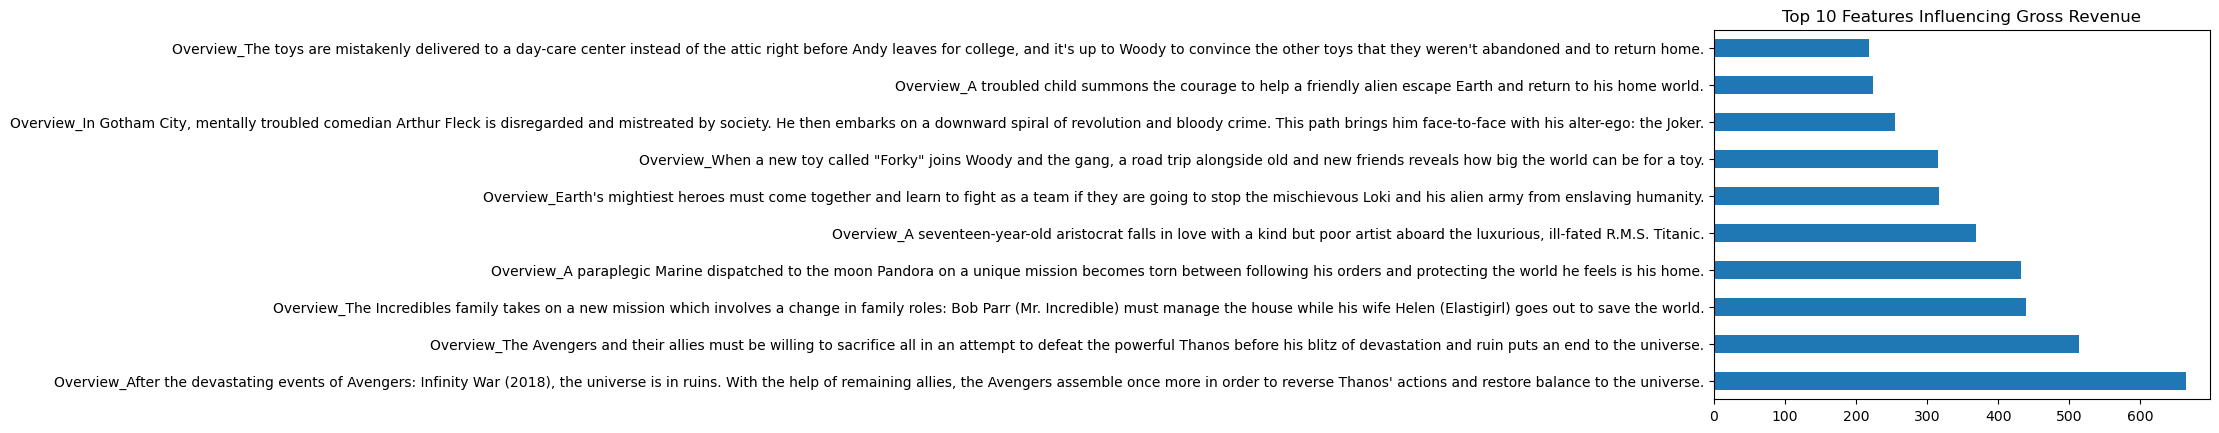

In [18]:
import matplotlib.pyplot as plt
coef=pd.Series(model.coef_,index=x.columns)
coef.nlargest(10).plot(kind="barh")
plt.title("Top 10 Features Influencing Gross Revenue")
plt.show()

##  Conclusion

The model provides reasonable prediction of movie revenue based on features like sentiment, votes, and genre.
This analysis demonstrates how data science supports strategic decisions in the film industry.
